In [1]:
# 데이터 불러오기
import pandas as pd
data_path = "/content/drive/MyDrive/data/processed_datasets"
df = pd.read_csv(data_path)
df.head()

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Attrition
0,0.446350,0.590048,0.742527,-1.010909,-0.891688,-0.660531,-1.224745,1.383138,0.379672,-0.057788,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1
1,1.322365,-0.913194,-1.297775,-0.147150,-1.868426,0.254625,0.816497,-0.240677,-1.026167,-0.057788,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
2,0.008343,0.590048,1.414363,-0.887515,-0.891688,1.169781,0.816497,1.284725,-1.026167,-0.961486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
3,-0.429664,-0.913194,1.461466,-0.764121,1.061787,1.169781,-1.224745,-0.486709,0.379672,-0.961486,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
4,-1.086676,0.590048,-0.524295,-0.887515,-1.868426,-1.575686,0.816497,-1.274014,0.379672,-0.961486,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [2]:
# X,y 분리
X = df.drop(columns='Attrition')
y = df['Attrition']

In [3]:
# train/test set 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=42)

In [21]:
# GridSearchCv를 위한 내부 교차 검증
## 데이터가 많지않아 valid 분리x -> K-Fold 효과적
## StratifiedKFold: K-Fold 할 시, 클래스 균형적으로 학습
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators':[100,200],
    'learning_rate':[0.05,0.1],
    'max_depth':[3,5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
scoring_list = ['accuracy','recall','f1']
scoring = scoring_list[2]

grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1       # 병렬처리
)
# 모델 학습
grid.fit(X_train,y_train)

# 최적의 성능의 모델 및 파라미터 저장
best_model = grid.best_estimator_
best_params = grid.best_params_
best_score = grid.best_score_

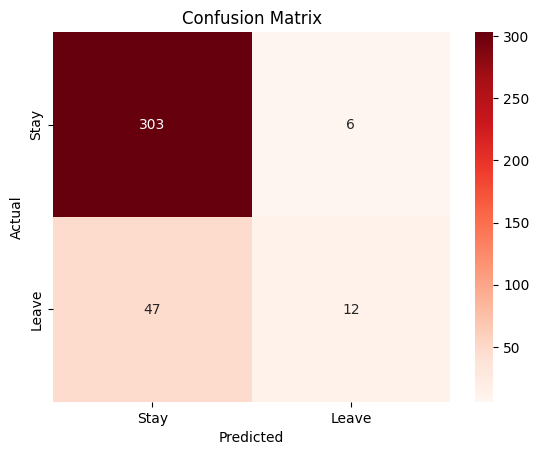

In [22]:
# 예측 수행
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

# Confusion Matrix 시각화
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',xticklabels=['Stay','Leave'], yticklabels=['Stay','Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [23]:
# 평가 출력
## 정밀도 : 모델이 이직할 것이라고 예측했을 때, 68%의 확률로 정확.
## 재현율 : 모델이 실제로 이직한 직원의 25%만 정확하게 식별.
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
print(f"Best Model: {best_model} with {scoring}")
print(f"Best Hyperparameters: {best_params}")
print(classification_report(y_test, y_pred))
print("==============================")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("==============================")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

Best Model: GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42) with f1
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       309
           1       0.67      0.20      0.31        59

    accuracy                           0.86       368
   macro avg       0.77      0.59      0.62       368
weighted avg       0.83      0.86      0.82       368

Accuracy: 0.8559782608695652
ROC AUC: 0.7869


In [18]:
# 1. Accuracy 기준 최적 threshold 찾기
from sklearn.metrics import accuracy_score

best_t = 0.0
best_acc = 0.0

def evaluate_threshold(y_true, y_proba,threshold):
    return (y_proba >= threshold).astype(int)

for t in range(1000):
    threshold = t / 1000
    y_pred = evaluate_threshold(y_test,y_proba,threshold)
    acc = accuracy_score(y_test,y_pred)
    if acc > best_acc:
        best_acc = acc
        best_t = threshold

print("[scoring: accuracy]")
print(f"  ▶ best threshold = {best_t:.2f}")
print(f"  ▶ best accuracy  = {best_acc:.4f}")

[scoring: accuracy]
  ▶ best threshold = 0.49
  ▶ best accuracy  = 0.8614


In [25]:
# 2. Recall 기준 최적 threshold 찾기
from sklearn.metrics import recall_score

best_t = 0.0
best_acc = 0.0
best_recall = 0.0

def evaluate_threshold(y_true, y_proba,threshold):
    return (y_proba >= threshold).astype(int)

for t in range(1000):
    threshold = t / 1000
    y_pred = evaluate_threshold(y_test, y_proba, threshold)
    recall = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    if recall >= 0.85 and acc > best_acc:
        best_t = threshold
        best_acc = acc
        best_recall = recall

print("[scoring: recall]")
print(f"  ▶ best threshold = {best_t:.2f}")
print(f"  ▶ best accuracy  = {best_acc:.4f}")

[scoring: recall]
  ▶ best threshold = 0.06
  ▶ best accuracy  = 0.5543


In [20]:
# 3. F1-score 기준 최적 threshold 탐색
from sklearn.metrics import f1_score

best_t = 0.0
best_acc = 0.0

def evaluate_threshold(y_true, y_proba,threshold):
    return (y_proba >= threshold).astype(int)

for t in range(1000):
    threshold = t / 1000
    y_pred = evaluate_threshold(y_test, y_proba, threshold)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    if f1 > f1_score(y_test, evaluate_threshold(y_test, y_proba, best_t)):
        best_t = threshold
        best_acc = acc

print("[scoring: f1]")
print(f"  ▶ best threshold = {best_t:.2f}")
print(f"  ▶ best accuracy  = {best_acc:.4f}")

[scoring: f1]
  ▶ best threshold = 0.12
  ▶ best accuracy  = 0.7962


In [ ]:
GradientBoostingClassifier(파생 변수 없음)
accuracy : 기본 acc 0.8560에 threshold=0.49에서 최대성능 0.8614
recall : 기본 acc 0.8587에 threshold=0.0에서 최대성능 0.0
f1 : 기본 acc 0.8560에 threshold=0.12에서 최대성능 0.7962